In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
from IPython.core.display import display, HTML

%matplotlib inline

In [86]:
# стиль графиков
sns.set(
    rc = {'figure.figsize' : (8,4)},
    style = 'whitegrid'
)

# Финальный проект. Вариант 2.

## Задание 1. A/B–тестирование
---
### Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### Входные данные

В качестве входных данных вы имеете 4 csv-файла:

- groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 


## Отчет по заданию 1.
---

## План исследования:

### 1.1. Предобработка данных

- 1.1.1. Загрузка данных в датафреймы
- 1.1.2. Анализ информации о данных
- 1.1.3. Сведение нужной информации в один датафрейм

### 1.2. Выбор метрик для проведения анализа. Разведочный анализ данных.

- 1.2.1. Формирование датафреймов контрольной и тестовой групп для исследования.
- 1.2.2. Выбор анализируемых метрик.
- 1.2.3. EDA и расчет метрик в контрольной и тестовой группах.

### 1.3. Проверка гипотез.

- 1.3.1. Выбор метода проверки для анализируемых метрик.
- 1.3.2. Выполнение расчетов.

### 1.4. Результаты исследования.
 
---

## 1.1. Предобработка данных

### 1.1.1. сохраняем предоставленные таблицы в датафреймы:

In [87]:
groups = pd.read_csv('groups.csv', sep = ';')
groups_add = pd.read_csv('groups_add.csv', sep = ',')
active_studs = pd.read_csv('active_studs.csv', sep = ';')
checks = pd.read_csv('checks.csv', sep = ';')

### 1.1.2. посмотрим информацию по созданным датафреймам:

In [88]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [89]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [90]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [91]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [92]:
# присоединим таблицу с дополнительным данными groups_add к основной таблице groups
groups = pd.concat([groups, groups_add])
groups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


Пропусков в данных нет.

Проверим, являются ли id пользователей уникальными (т.е. убедимся, что в каждой из таблиц по каждому из пользователей есть только одна запись). Для этого сравним количество записей в колонке `id` (или `student_id`)и количество уникальных записей из этой же колонки. 

Если результаты одинаковы - значит, все записи в колонке уникальны.

Напишем для этого простую функцию `is_unique`

In [93]:
# Функция определяет, являются ли уникальными записи в первой колонке датафрейма (индекс колонки [0])
def is_unique (data):
    a = data.iloc[:,0].count()
    b = data.iloc[:,0].nunique()
    if a != b:
        return False
    else:
        return True

Если повторения есть, сообщение об этом сделаем более крупным и красного цвета, а также выведем список is_uniq, в котором позиция значения False соответствует таблице, имеющей повторения.

In [94]:
is_uniq=[]
is_uniq.extend([is_unique(groups), is_unique(active_studs), is_unique(checks)])

if all(is_uniq):
    display(HTML('<font color="green"> Все значения id в таблицах уникальны </font>'))
else:
    display(HTML('<font color="red", size=6> В одной из таблиц есть повторяющиеся id! </font>'))
    print(is_uniq)
    

### 1.1.3. Сведение нужной информации в один датафрейм

Сведем информацию из таблиц в единый датафрейм `stud_info`. 

Выполним дважды `left join`, соединяя последовательно таблицы `groups`, `active_studs` и `checks`.

Тогда в итоговую таблицу попадут все пользователи из таблицы `groups`. При этом пользователи, которые были НЕ активны, также присоединятся, но в колонке `student_id` у них будет значение `NaN`. 

После присоединения таблицы `checks` переименуем колонку `student_id_x` (она присоединилась из таблицы `active_studs`) в `is_active` и дропнем колонку с id студентов этой колонки, оставим только значения чеков.

In [95]:
stud_info=groups.merge(active_studs, how = 'left', left_on = 'id', right_on='student_id')\
    .merge(checks, how = 'left', left_on = 'id', right_on='student_id')\
    .rename(columns={'student_id_x':'is_active'})\
    .drop(['student_id_y'], axis=1)
stud_info.head()

,id,grp,is_active,rev
0,1489,B,NaN,NaN
1,1627,A,1627.0,990.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN


In [96]:
# проверим, не потеряли ли мы данные при присоединении таблиц:
stud_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         74576 non-null  int64  
 1   grp        74576 non-null  object 
 2   is_active  8341 non-null   float64
 3   rev        541 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.8+ MB


Количество не нулевых записей в колонке `rev` совпадает с количеством записей в таблице `checks`. Количество не нулевых записей в колонке `is_active` тоже совпадает с с количеством записей в таблице `active_studs`. Общее количество пользователей в полученном датафрейме равно сумме записей в таблицах `groups` и `groups_add`.

In [97]:
# для удобства заменим значения колонки is_active: 
# 1 - если пользователь был активен в период эксперимента, 0 - если не был активен.
stud_info.is_active = stud_info.is_active.apply(lambda x: 1 if x > 0 else 0)

In [98]:
# посмотрим на результат:
stud_info.head()

,id,grp,is_active,rev
0,1489,B,0,NaN
1,1627,A,1,990.0
2,1768,B,0,NaN
3,1783,B,0,NaN
4,1794,A,0,NaN


In [99]:
# округлим значения выручки до 2 знаков после запятой:
stud_info.rev = stud_info.rev.round(2)

In [100]:
# избавимся от значений NaN
stud_info.rev = stud_info.rev.fillna(0)

In [101]:
# добавим категориальную колонку is_pay, чтобы отметить всех оплативших посетителей
stud_info['is_pay'] = stud_info.rev.apply(lambda x: 1 if x > 0 else 0)

In [102]:
stud_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         74576 non-null  int64  
 1   grp        74576 non-null  object 
 2   is_active  74576 non-null  int64  
 3   rev        74576 non-null  float64
 4   is_pay     74576 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 3.4+ MB


Таким образом, сформированный единый датафрейм stud_info можно использовать далее для анализа нужных показателей в контрольной и тестовой группах

---

## 1.2. Выбор метрик для проведения анализа. Разведочный анализ данных.

### 1.2.1. Формирование датафреймов контрольной и тестовой групп для исследования.

In [103]:
# Посмотрим на количество пользователей по группам: общее количество, активные, платящие (из общего количества).
stud_info \
    .groupby('grp') \
    .agg(total=('id', 'count'), active=('is_active', 'sum'), total_paing=('is_pay', 'sum'))

,total,active,total_paing
grp,,,
A,14693,1538,107
B,59883,6803,434


Мы видим, что количество активных (т.е. заходивших на сайт в период эксперимента) пользователей существенно меньше того количества пользователей, которых мы включили в эксперимент, а также, что контрольная группа в несколько раз меньше тестовой.

С одной стороны, те пользователи, которые включены в эксперимент в группы А и В и не заходили на сайт в период эксперимента, могут рассматриваться как пользователи, не имевшие доступа к новой механике оплаты услуг и условно их можно включить в контрольную группу.

С другой стороны, мы не можем исключить влияния других факторов на этих пользователей - как давно они делали оплаты? Тестировались ли в этот момент другие изменения? 

Поэтому сформируем два датафрейма по группам, в которые войдут только активные пользователи.

In [104]:
# разделим пользователей на две группы: А - контрольная группа, B - тестовая группа

control = stud_info.query('grp == "A" and is_active == 1')
test = stud_info.query('grp == "B" and is_active == 1')

Посмотрим информацию по полученным датафреймам

In [105]:
control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1538 entries, 1 to 74558
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1538 non-null   int64  
 1   grp        1538 non-null   object 
 2   is_active  1538 non-null   int64  
 3   rev        1538 non-null   float64
 4   is_pay     1538 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 72.1+ KB


In [106]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6803 entries, 10 to 74562
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         6803 non-null   int64  
 1   grp        6803 non-null   object 
 2   is_active  6803 non-null   int64  
 3   rev        6803 non-null   float64
 4   is_pay     6803 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 318.9+ KB


In [107]:
# Посчитаем долю посетителей, выполнивших оплату 
# В контрольной группе:
control.is_pay.sum() / control.id.count()

0.05071521456436931

In [108]:
# В тестовой группе:
test.is_pay.sum() / test.id.count()

0.046156107599588415

Таким образом, в контрольной группе оплатили всего 5.1% посетителей, а в тестовой еще меньше - 4.6%

---
### 1.2.2. Выбор анализируемых метрик.

Определим, по каким метрикам оценивать результаты А/Б тестирования.

На наш взгляд, изменение механики оплаты услуг (например, уменьшение количества шагов до оплаты, отсутствие дополнительных подтверждений, проведение транзакций без необходимости перехода на сайт банка, и т.д.) может положительно повлиять на простоту и доступность оплаты.

В первую очередь, уменьшение трудоемкости оплаты может повлиять на конверсию из посещения сайта в покупку.


Во-вторых, можем предположить,что и выручка с покупателей, заходивших на сайт в период эксперимента, изменится. 

В таблице `checks` содержится уже сгруппированная по покупателям информация о суммах их оплат - можно проанализировать, как изменится выручка с посетителей (ARPU) или с покупателей (ARPPU) в контрольной и тестовой группах. 

**Проведем проверку гипотез об улучшении трех метрик:**

1. **Средняя выручка с посетителя (ARPU)** - проверим гипотезу о том, что посетители в среднем стали платить больше.
2. **Средняя выручка с покупателя (ARPPU)** - проверим гипотезу о том, что покупатели в среднем стали платить больше.
3. **Конверсия из посещения сайта в покупку (CR)** - оценим отношение количества купивших посетителей к общему количеству активных посетителей - проверим, стали ли более охотно покупать посетители.


### 1.2.3. EDA и расчет метрик в контрольной и тестовой группах.

---
Посмотрим описательные статистики выручки в группах:

In [109]:
control.rev.describe()

count    1538.000000
mean       47.347204
std       290.490632
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3660.000000
Name: rev, dtype: float64

In [110]:
test.rev.describe()

count    6803.000000
mean       58.058798
std       313.770198
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4650.000000
Name: rev, dtype: float64

Мы видим, что все квартили равны 0. Значит, большая часть значений выручки равна 0.
Посмотрим на показатели только заплативших посетителей.

In [111]:
control.query('rev > 0').rev.describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [112]:
test.query('rev > 0').rev.describe()

count     314.000000
mean     1257.878981
std       790.864245
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

**Визуализируем данные.**

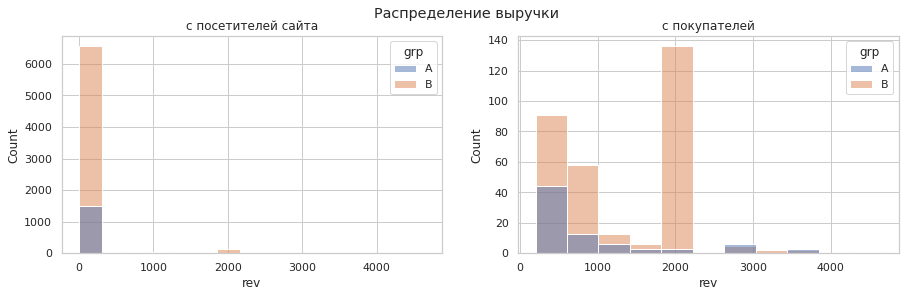

In [113]:
# Распределения пользователей и покупателей (заплативших пользователей) контрольной и тестовой выборок
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Распределение выручки')

sns.histplot(data = stud_info.query('is_active > 0'), x = 'rev', hue='grp', ax=axes[0])
axes[0].set_title('с посетителей сайта')

sns.histplot(data = stud_info.query('is_active > 0 and rev>0'), x = 'rev', hue='grp', ax=axes[1])
axes[1].set_title('с покупателей')

plt.show()

Распределение выручки по посетителям характеризуется тем, что около 95% наблюдений равны 0.
Распределение выручки среди тех, кто купил, больше напоминает экспоненциальное. Следует обратить внимание на моду распределения тестовой группы - большое количество покупателей сделали оплаты в районе 2000, чего не наблюдается в контрольной группе.

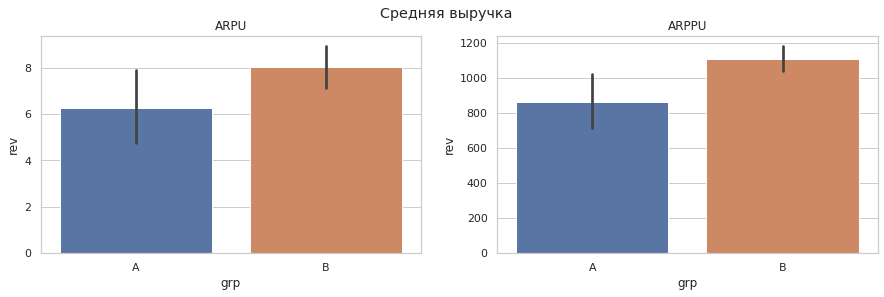

In [114]:
# Средняя выручка
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Средняя выручка')

sns.barplot(data=stud_info.sort_values('grp'), y='rev', x='grp', ax=axes[0])
axes[0].set_title('ARPU')

sns.barplot(data=stud_info.query('rev>0'), y='rev', x='grp', ax=axes[1])
axes[1].set_title('ARPPU')

plt.show()

Видим, что ARPU и ARPPU в тестовой группе выросли. 

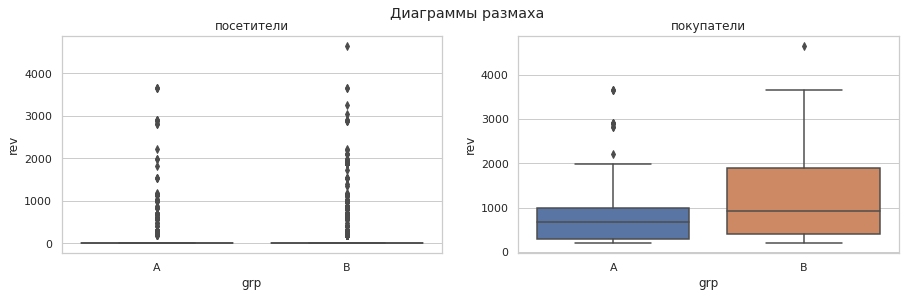

In [115]:
# боксплоты
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Диаграммы размаха')

sns.boxplot(data=stud_info.sort_values('grp'), x='grp', y='rev', ax=axes[0])
axes[0].set_title('посетители')

sns.boxplot(data=stud_info.query('rev > 0'), x='grp', y='rev', ax=axes[1])
axes[1].set_title('покупатели')

plt.show()

Боксплот по посетителям не информативен, что и понятно - ведь все отличающиеся от 0 значения обрабатываются как выбросы.
А на боксплоте по покупателям мы видим существенный выброс. Максимальная выручка с покупателя 4650, а с посетителя 3660. 

Посмотрим, сколько всего оплативших 3500 и более.

In [116]:
control.query('rev >= 3500')

,id,grp,is_active,rev,is_pay
9916,445767,A,1,3660.0,1
36243,1624158,A,1,3660.0,1
44395,2150601,A,1,3660.0,1


In [117]:
test.query('rev >= 3500')

,id,grp,is_active,rev,is_pay
17483,829330,B,1,3660.0,1
38102,1711305,B,1,4650.0,1
72633,5316551,B,1,3660.0,1


В тестовой группе есть всего один покупатель с оплатой 4650 (id = 1711305). Интересно посмотреть, насколько влияет этот выброс на дисперсию и среднее.

Сравним, какими будут характеристики распределения с ним и без него.

In [118]:
test.query('rev > 0').rev.describe()

count     314.000000
mean     1257.878981
std       790.864245
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [119]:
test.query('rev > 0 and id != 1711305').rev.describe()

count     313.000000
mean     1247.041534
std       768.422649
min       199.000000
25%       489.000000
50%      1140.000000
75%      1900.000000
max      3660.000000
Name: rev, dtype: float64

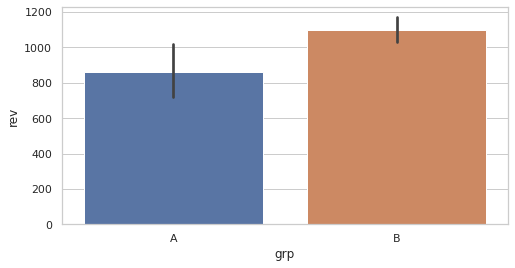

In [120]:
sns.barplot(data=stud_info.query('rev>0 and id != 1711305'), y='rev', x='grp')

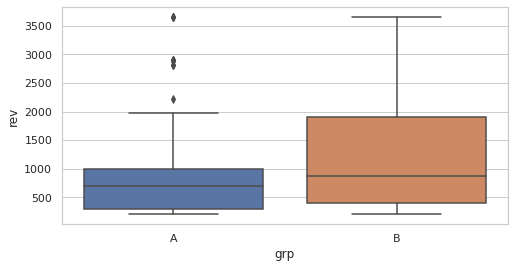

In [121]:
sns.boxplot(data=stud_info.query('rev > 0 and id != 1711305'), x='grp', y='rev')

Медиана не изменилась (ожидаемо), среднее значение уменьшилось на 10, стандартное отклонение тоже уменьшилось (с 790 до 768). Коэффициент вариации (std/mean) снизился с 0.63 до 0.62. Влияние кажется не значительным, оставим всех пользователей в выборках.

---
**Посчитаем метрики**

In [122]:
arpu_c = round(control.rev.sum() / control.id.count(), 2)
arpu_t = round(test.rev.sum() / test.id.count(), 2)

In [123]:
arppu_c = round(control.rev.sum() / control.is_pay.sum(), 2)
arppu_t = round(test.rev.sum() / test.is_pay.sum(), 2)

In [124]:
# конверсия в контрольной группе:
cr_c = 100*control.is_pay.mean()
# конверсия в тестовой группе:
cr_t = 100*test.is_pay.mean()

Для сравнения выведем метрики.

In [125]:
print(f'''
ARPU контрольной группы: {arpu_c}
ARPU тестовой группы:    {arpu_t}

ARPPU контрольной группы: {arppu_c}
ARPPU тестовой группы:    {arppu_t}
''')
print(f'''
Конверсия в контрольной группе: {cr_c:.2f}%
Конверсия в тестовой группе:    {cr_t:.2f}%
''')


ARPU контрольной группы: 47.35
ARPU тестовой группы:    58.06

ARPPU контрольной группы: 933.59
ARPPU тестовой группы:    1257.88


Конверсия в контрольной группе: 5.07%
Конверсия в тестовой группе:    4.62%



Видим, чтоARPU и ARPPU у тестовой группы больше, а конверсия - наоборот - меньше.

---
## 1.3. Проверка гипотез.

### 1.3.1. Выбор метода проверки для анализируемых метрик.

**1. Выбираем метод проверки гипотез о средней выручке (ARPU, ARPPU).**

Видно, что распределения выручки не являются нормальными. Кроме того, распределения имеют очень высокую вариативность.

При таком распределении использовать t-test не самый надежный вариант. Можно воспользоваться непараметрическим тестом Манна-Уитни или использовать bootstrap.

Остановимся на втором варианте - **применим bootstrap** для контрольной и тестовой выборок значений выручки, проверять будем среднее значение.

**2. Выбираем метод проверки гипотезы о конверсии.**

Поскольку мы имеем дело с категориальной переменной, для проверки статзначимости отличий конверсии можно воспользоваться критерием согласия Пирсона. Для проверки также можно использовать t-тест, так как если мы возьмем выборку из 0 и 1 (т.е. не купил или купил), то оценка среднего из такой выборки как раз и является конверсией.
**Применим для проверки конверсии t-тест.**


---

### 1.3.2. Выполнение расчетов.

### Оценка ARPU и ARPPU.

Oценим 95% доверительные интервалы для средних значений в контрольной и тестовой группах с помощью bootstrap. Если они пересекутся - то это будет говорить в пользу нулевой гипотезы (различия, вполне возможно, не статзначимы). Если доверительные интервалы не пересекутся - то различия скорее статистически значимы.


In [126]:
# ARPU bootstrap
arpu_c_res = sps.bootstrap((control.rev,), np.mean)
arpu_t_res = sps.bootstrap((test.rev,), np.mean)

In [127]:
# ARPPU bootstrap
arppu_c_res = sps.bootstrap((control.query('rev > 0').rev,), np.mean)
arppu_t_res = sps.bootstrap((test.query('rev > 0').rev,), np.mean)

In [132]:
# Посмотрим, чему равны доверительные интервалы
print(f'''

Доверительные интервалы ARPU:
    Контрольная группа: {arpu_c_res.confidence_interval};
    Тестовая группа   : {arpu_t_res.confidence_interval};
Доверительные интервалы ARPPU:
    Контрольная группа: {arppu_c_res.confidence_interval};
    Тестовая группа   : {arppu_t_res.confidence_interval}.    
''')




Доверительные интервалы ARPU:
    Контрольная группа: ConfidenceInterval(low=34.934375416246766, high=64.73890899984303);
    Тестовая группа   : ConfidenceInterval(low=51.15239979053985, high=65.79769504514624);
Доверительные интервалы ARPPU:
    Контрольная группа: ConfidenceInterval(low=758.4886677697646, high=1166.2942350873222);
    Тестовая группа   : ConfidenceInterval(low=1171.3059817523867, high=1347.7261146496814).    



Проверим, пересекаются ли доверительные интервалы средних, рассчитанные с помощью bootstrap.

In [128]:
# для улучшения читаемости кода напишем простую функцию, которая проверяет, пересекаются ли интервалы
def intersect_checker (res_c, res_t, metric_name='Название метрики'):
    c = res_c.confidence_interval
    t = res_t.confidence_interval
    print(f'Проверка метрики {metric_name}')
    if (c.high > t.low and c.high < t.high) or (c.low < t.high and c.low > t.low):
        print('доверительные интервалы пересекаются')
    else:
        print('доверительные интервалы не пересекаются')

In [129]:
# ARPU
intersect_checker(arpu_c_res, arpu_t_res, 'arpu')

Проверка метрики arpu
доверительные интервалы пересекаются


In [130]:
# ARPPU
intersect_checker(arppu_c_res, arppu_t_res, 'arppu')

Проверка метрики arppu
доверительные интервалы не пересекаются


---
### Оценка конверсии.

Используем t-тест: мы можем провести оценку среднего по колонке `is_pay` (т.е. как раз конверсии) в двух группах.

Нулевая гипотеза - расхождение между конверсиями контрольной и тестовой групп случайны, и не имеют статистической значимости.

Альтернативная гипотеза - данное расхождение статистически значимо, и вызвано в том числе новой механикой оплаты.

In [133]:
result_cr = sps.ttest_ind(control.is_pay, test.is_pay)
print(f'Оценка конверсии: p_value = {result_cr.pvalue}')

Оценка конверсии: p_value = 0.445530545137386


Поскольку значение p-value больше 0.05 (причем значительно), можно довольно уверенно отвергнуть альтернативную гипотезу в пользу нулевой.

---
Также в качестве дополнительного варианта применим для проверки гипотез критерий согласия Пирсона (хи-квадрат).
Нулевая гипотеза - предположение, что количество оплативших пользователей в группе не зависит от того, какая механика оплаты реализована.
Альтернативная гипотеза заключается в том, что количество оплативших пользователей в группе все же зависит от механики оплаты.

In [137]:
#сформируем таблицу сопряженности:
tab = pd.crosstab(stud_info.query('is_active==1').grp, stud_info.is_pay)
tab

is_pay,0,1
grp,,
A,1460,78
B,6489,314


In [138]:
res_chisquare=sps.chi2_contingency(tab)
# print(f'p_value= {res_chisquare[1]}')
res_chisquare

(0.48480826522557896,
 0.48625240457231045,
 1,
 array([[1465.71897854,   72.28102146],
        [6483.28102146,  319.71897854]]))

При расчете данного теста мы также получили значение p-value существенно больше 0.05, что также подтверждает высокую вероятность того, что расхождение конверсии в контрольной и тестовой группах случайно и не вызвано влиянием механики оплаты услуг.

---
# 1.4. Результаты исследования.

Проанализируем полученные результаты.

**ARPU**


In [140]:
# Средняя выручка с посетителей в тестовой группе, изменения в %
growth = round(100*(arpu_t-arpu_c) / arpu_c, 2)
growth

22.62

Довольно существенный рост. Однако проверка расхождений говорит о том, что гипотеза о статистической значимости отличий не подтверждается: доверительные интервалы средних в контрольной группе пересекаются.
Высока вероятность того, что различия вызваны случайными факторами и наша новая механика оплаты существенно не повлияла на ARPU.

**ARPPU**

In [153]:
# Средняя выручка с посетителей в тестовой группе, изменения в %
growth2 = round(100*(arppu_t-arppu_c) / arppu_c, 2)
growth2

34.74

Тут относительный прирост еще выше. Доверительные интервалы, рассчитанные с помощью bootstrap, не пересекаются.
Но нижняя граница интервала тестовой группы и верхняя граница контрольной группы очень близко друг к другу.

Попробуем еще раз оценить arppu, на этот раз не учитывая выброс rev=4650 в тестовой группе.

In [154]:
arppu_t2_res = sps.bootstrap((test.query('0 < rev < 4600').rev,), np.mean)

In [155]:
arppu_t2_res.confidence_interval

ConfidenceInterval(low=1163.5038920987888, high=1332.4445938760007)

In [156]:
intersect_checker(arppu_c_res, arppu_t2_res, 'arppu_filt')

Проверка метрики arppu_filt
доверительные интервалы пересекаются


Выброс, таким образом, меняет результат в противоположную сторону. Делать однозначный вывод о статистической значимости отличий ARPPU я бы не стал. 

Попробуем посмотреть, какой результат покажет t-тест

In [157]:
sps.ttest_ind(control.query('rev>0').rev, test.query('rev>0').rev)

Ttest_indResult(statistic=-3.133779424369783, pvalue=0.0018562030244934635)

In [158]:
# без значения rev=4650
sps.ttest_ind(control.query('rev>0').rev, test.query('0 < rev < 4600').rev)

Ttest_indResult(statistic=-3.093401523757841, pvalue=0.002121631487105392)

Как видим, т-тест дает в обоих случаях pvalue меньше, чем 0.05 - что может служить основанием для вывода о справедливости альтернативной гипотезы.

К сожалению, мне пока не хватает опыта и знаний, чтобы уверенно ответить на вопрос - а можно ли в случае ARPPU принять альтернативную гипотезу? Появляется множество вопросов - а какой из тестов имеет бОльшую мощность? Можно ли использовать t-тест на выборках с не нормальным распределением (и если можно, то какого размера должна быть такая выборка) и т.д.

Поэтому я бы сделал вывод, что нужны дополнительные данные, а также попробовал посмотреть, как собирались данные и какова природа больших оплат - можно ли как-то поработать с выбросами на этапе сбора данных и т.п. 

**Конверсия**

t-тест показал, что отличия в конверсии в двух группах, скорее всего, не имеют статистической значимости; проведенный расчет критерия Пирсона подтвердил это.

Поэтому по конверсии сделаем вывод - введение новой механики оплаты услуг с большой вероятностью не повлияло на конверсию из посетителя в покупателя.

---

Задания 2 и 3 находятся в отдельных файлах
v2_task2.ipynb
v2_task3.ipynb